by: Artyom Kurguzkin (kurg0002)


This notebook is failrly big. I used markdown headings to orginse it. I recommend using some markdown-based outline extension that can help you navigate it.

# Exploring and preparing Data
---

### Libaries imports

In [32]:
import numpy as np
import pandas as pd
from itertools import product

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, IsolationForest, BaggingRegressor, RandomForestRegressor, BaggingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score

## Data Overview


In [105]:
# note, the location of the data file may very, so you have to change the path to fit your work setup
df = pd.read_csv('work/GameData.csv')
df.shape

(403, 386)

In [92]:
unique_counts = df.iloc[:, -5:].nunique()

print(unique_counts)

Category        6
Region         21
OriginYear    165
BestAgent       6
UCT           122
dtype: int64


In [39]:
# List the unique values in the fourth-to-last column
unique_values = df.iloc[:, -5].unique()

print(unique_values)

['Race' 'War' 'Hunt' 'Sow' 'Space' 'Puzzle']


In [391]:
selected_columns = df[['Category', 'Region', 'BestAgent', 'OriginYear']]

# Calculate the counts of unique values for each column
unique_counts = {col: selected_columns[col].value_counts() for col in selected_columns.columns}

# Print the unique counts for each column
for col, counts in unique_counts.items():
    print(f"\nCounts for {col}:")
    print(counts)


Counts for Category:
Category
War       131
Sow        75
Space      69
Hunt       64
Race       57
Puzzle      7
Name: count, dtype: int64

Counts for Region:
Region
Southern Asia        83
Eastern Africa       41
Southern Europe      38
Western Africa       32
Northern Asia        31
Northern Europe      31
Southeastern Asia    27
Eastern Asia         24
Northern Africa      21
Northern America     20
Western Asia         10
Middle Africa         7
Eastern Europe        7
Central Asia          7
Western Europe        7
South America         5
Caribbean             4
Polynesia             3
Central America       2
Micronesia            2
Southern Africa       1
Name: count, dtype: int64

Counts for BestAgent:
BestAgent
Alpha-Beta             234
MAST                    56
UCT                     52
Progressive History     37
Random                  13
MC-GRAVE                11
Name: count, dtype: int64

Counts for OriginYear:
OriginYear
 1963    21
 1955    16
 1283    13
 1951    1

In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)     # Show all rows (if needed)

df.head(5)

,GameName,String_java.lang.String,Off_int,End_int,int_int,Undefined_int,Piece_game.equipment.component.Piece,Board_game.equipment.container.board.Board,MancalaBoard_game.equipment.container.board.custom.MancalaBoard,Track_game.equipment.container.board.Track,Dice_game.equipment.container.other.Dice,Hand_game.equipment.container.other.Hand,Equipment_game.equipment.Equipment,Map_game.equipment.other.Map,Regions_game.equipment.other.Regions,All_game.functions.booleans.all.All,Can_game.functions.booleans.can.Can,Is_game.functions.booleans.is.Is,And_game.functions.booleans.math.And,Equals_game.functions.booleans.math.Equals,Ge_game.functions.booleans.math.Ge,Gt_game.functions.booleans.math.Gt,If_game.functions.booleans.math.If,Le_game.functions.booleans.math.Le,Lt_game.functions.booleans.math.Lt,Not_game.functions.booleans.math.Not,NotEqual_game.functions.booleans.math.NotEqual,Or_game.functions.booleans.math.Or,No_game.functions.booleans.no.No,Was_game.functions.booleans.was.Was,Mul_game.functions.dim.math.Mul,Difference_game.functions.directions.Difference,Directions_game.functions.directions.Directions,If_game.functions.directions.If,Div_game.functions.floats.math.Div,Mul_game.functions.floats.math.Mul,Sub_game.functions.floats.math.Sub,Square_game.functions.graph.generators.basis.square.Square,Tri_game.functions.graph.generators.basis.tri.Tri,Concentric_game.functions.graph.generators.shape.concentric.Concentric,Rectangle_game.functions.graph.generators.shape.Rectangle,Regular_game.functions.graph.generators.shape.Regular,Repeat_game.functions.graph.generators.shape.Repeat,Spiral_game.functions.graph.generators.shape.Spiral,Wedge_game.functions.graph.generators.shape.Wedge,Add_game.functions.graph.operators.Add,Hole_game.functions.graph.operators.Hole,MakeFaces_game.functions.graph.operators.MakeFaces,Merge_game.functions.graph.operators.Merge,Remove_game.functions.graph.operators.Remove,Rotate_game.functions.graph.operators.Rotate,Scale_game.functions.graph.operators.Scale,Shift_game.functions.graph.operators.Shift,SplitCrossings_game.functions.graph.operators.SplitCrossings,Array_game.functions.intArray.array.Array,Results_game.functions.intArray.math.Results,Union_game.functions.intArray.math.Union,Values_game.functions.intArray.values.Values,Ahead_game.functions.ints.board.Ahead,CentrePoint_game.functions.ints.board.CentrePoint,Column_game.functions.ints.board.Column,Coord_game.functions.ints.board.Coord,HandSite_game.functions.ints.board.HandSite,Id_game.functions.ints.board.Id,MapEntry_game.functions.ints.board.MapEntry,RegionSite_game.functions.ints.board.RegionSite,Row_game.functions.ints.board.Row,Where_game.functions.ints.board.where.Where,Count_game.functions.ints.count.Count,Face_game.functions.ints.dice.Face,Between_game.functions.ints.iterator.Between,From_game.functions.ints.iterator.From,Level_game.functions.ints.iterator.Level,Pips_game.functions.ints.iterator.Pips,Player_game.functions.ints.iterator.Player,Site_game.functions.ints.iterator.Site,To_game.functions.ints.iterator.To,Last_game.functions.ints.last.Last,Add_game.functions.ints.math.Add,Div_game.functions.ints.math.Div,If_game.functions.ints.math.If,Max_game.functions.ints.math.Max,Min_game.functions.ints.math.Min,Mod_game.functions.ints.math.Mod,Mul_game.functions.ints.math.Mul,Sub_game.functions.ints.math.Sub,Size_game.functions.ints.size.Size,TopLevel_game.functions.ints.stacking.TopLevel,Amount_game.functions.ints.state.Amount,Counter_game.functions.ints.state.Counter,Mover_game.functions.ints.state.Mover,Next_game.functions.ints.state.Next,Pot_game.functions.ints.state.Pot,Score_game.functions.ints.state.Score,State_game.functions.ints.state.State,Var_game.functions.ints.state.Var,What_game.functions.ints.state.What,Who_game.functions.ints.state.Who,TrackSite_game.functions.ints.trackSite.TrackSite,Value_game.functions.ints.value.Value,Exact_game.functions.range.math.Exact,Max_game.functions.range.math.Max,Min_game.functions.range.math.Min,Range_

* last 5 collumns: labels to be predicted. Collumns [0-381] - ludemes - game properties. Lots of them seems like binary values.

<br>

In [9]:
# Get the number of unique values for each column
nunique = df.nunique()

# Classify columns based on their unique values and data types
binary_cols = nunique[nunique == 2].index.tolist()  # Binary columns with exactly 2 unique values
categorical_cols = nunique[nunique > 2].index.tolist()  # Categorical columns with > 2 unique values
continuous_cols = df.select_dtypes(include=[np.float64, np.float32]).columns.tolist()  # Continuous columns with decimal values

# Print the names of continuous columns and their unique values
if continuous_cols:  # Only proceed if there are continuous columns
    print("\nContinuous Columns and Their Unique Values:\n")
    for col in continuous_cols:
        unique_values = df[col].unique()
        print(f"{col}: {unique_values}")
else:
    print("No continuous columns found.")



Continuous Columns and Their Unique Values:

int_int: [ 18.  nan 203. 116.   7.   4.  10.   6.  39.   2.  92.  43.   3.]
Board_game.equipment.container.board.Board: [ 1. nan  0.]
Equipment_game.equipment.Equipment: [ 1. nan]
To_game.functions.ints.iterator.To: [8.000e+00 2.100e+01 1.500e+01 0.000e+00 3.000e+00 2.300e+01 6.800e+01
 8.400e+01 2.000e+00 9.000e+00 1.000e+01 4.000e+00 5.000e+00 1.600e+01
 1.000e+00 1.200e+01 6.000e+00 7.000e+00 1.800e+01 3.200e+01 2.000e+01
 1.700e+01 1.400e+01 1.300e+01 2.800e+01 2.200e+01 1.900e+01 6.600e+01
 2.500e+01 3.400e+01       nan 5.200e+01 1.100e+01 3.100e+01 1.353e+03
 3.800e+01 1.690e+02 9.200e+01 4.600e+01 7.310e+02]
UCT: [ 64.          43.          41.          53.          72.
  54.          55.5         47.5         49.          35.
  40.5         47.          48.5         49.5         70.
  72.5         76.5         79.          60.          38.
  37.5         36.5         30.5         58.5         68.
  51.          71.          46.75   

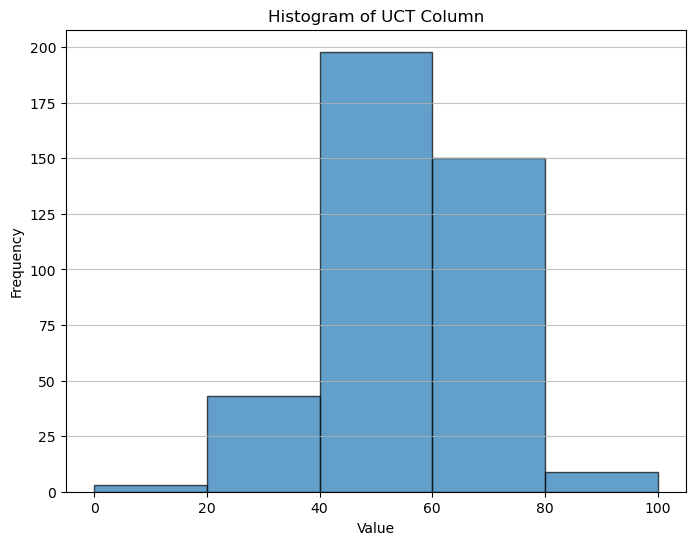

In [22]:
uct_data = df['UCT'].dropna()

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(uct_data, bins=5, edgecolor='black', alpha=0.7)
plt.title('Histogram of UCT Column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Drop NA values

Make sure all collumns have appropriate datatype assigned to them

In [106]:
def convert_numeric(column):
    # Attempt to convert to numeric; if it fails, keep original values
    return pd.to_numeric(column, errors='coerce').fillna(column)

# Apply the conversion function to each column
for col in df.columns:
    if df[col].dtype == 'object':  # Check if the column contains string values
        df[col] = convert_numeric(df[col])
df.head()

,GameName,String_java.lang.String,Off_int,End_int,int_int,Undefined_int,Piece_game.equipment.component.Piece,Board_game.equipment.container.board.Board,MancalaBoard_game.equipment.container.board.custom.MancalaBoard,Track_game.equipment.container.board.Track,...,FRR_game.util.directions.RelativeDirection,BR_game.util.directions.RelativeDirection,BRR_game.util.directions.RelativeDirection,SameDirection_game.util.directions.RelativeDirection,OppositeDirection_game.util.directions.RelativeDirection,Category,Region,OriginYear,BestAgent,UCT
0,Senet,55,2,2,18.0,0,1,1.0,0,2,...,0,0,0,0,0,Race,Northern Africa,-2970,Progressive History,64.0
1,Ludus Latrunculorum,7,0,0,NaN,0,1,1.0,0,0,...,0,0,0,0,0,War,Northern Africa,-180,Alpha-Beta,43.0
2,XII Scripta,8,3,3,NaN,0,1,1.0,0,2,...,0,0,0,0,0,Race,Northern Africa,-100,Alpha-Beta,41.0
3,Mehen,25,4,6,203.0,0,3,1.0,0,2,...,0,0,0,0,0,War,Northern Africa,-3300,MAST,53.0
4,20 Squares,16,1,1,116.0,0,1,1.0,0,2,...,0,0,0,0,0,Race,Northern Africa,-2300,MAST,72.0


In [107]:
for col in df.columns:
    # Count NA values
    na_count = df[col].isna().sum()
    total_count = df[col].shape[0]
    na_percentage = (na_count / total_count) * 100

    if na_percentage > 40:
        # Drop the column if NA percentage is more than 40%
        df.drop(col, axis=1, inplace=True)
        print(f"Dropped column: {col} (NA percentage: {na_percentage:.2f}%)")
    elif na_count > 0:  # Check if there are any NA values to substitute
        # Substitute NA with the most popular value (mode)
        most_common_value = df[col].mode()[0] if not df[col].mode().empty else np.nan
        substituted_count = df[col].isna().sum()  # Count before substitution
        
        # Fill NA and assign back to the column to avoid warning
        df[col] = df[col].fillna(most_common_value)
        
        substituted_count -= df[col].isna().sum()  # Count after substitution
        print(f"Column: {col}, substituted {substituted_count} NA(s) with: {most_common_value}")

Dropped column: int_int (NA percentage: 96.53%)
Column: Board_game.equipment.container.board.Board, substituted 1 NA(s) with: 1.0
Column: Equipment_game.equipment.Equipment, substituted 1 NA(s) with: 1.0
Column: To_game.functions.ints.iterator.To, substituted 3 NA(s) with: 1.0


We dropped on of the collumns that had most of its contents set to NA - it won't be helpful to us.

## Search for and remove outliers

drop unique names

In [108]:
df.drop(df.columns[0], axis=1, inplace=True)
df.shape

(403, 384)

In [109]:
# Select only the remaining numerical columns (excluding the last 5)
numerical_cols = df.iloc[:, :-5]

# contamination=0.1 - we expect about 10% of of the data to be outliers
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model on the numerical columns
iso_forest.fit(numerical_cols)

# Predict outliers (-1 means outlier, 1 means inlier)
outliers = iso_forest.predict(numerical_cols)

# Add a column for outlier results to the numerical columns DataFrame
df['outlier'] = outliers

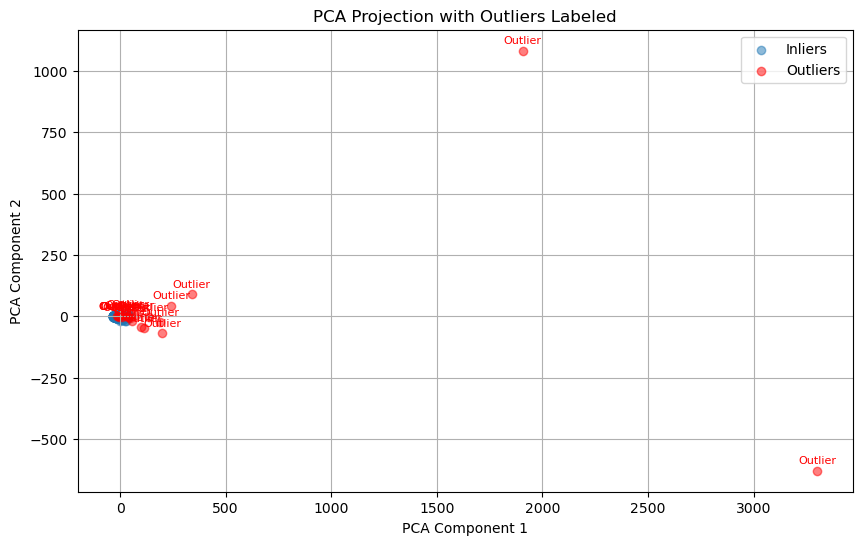

In [110]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(numerical_cols)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[df['outlier'] == 1][:, 0], X_pca[df['outlier'] == 1][:, 1], alpha=0.5, label='Inliers')
plt.scatter(X_pca[df['outlier'] == -1][:, 0], X_pca[df['outlier'] == -1][:, 1], color='red', alpha=0.5, label='Outliers')

# Annotate outliers
for i in range(len(X_pca)):
    if outliers[i] == -1:  # Only label outliers
        plt.annotate('Outlier', (X_pca[i, 0], X_pca[i, 1]), textcoords="offset points", 
                     xytext=(0, 5), ha='center', fontsize=8, color='red')

# Plot configuration
plt.title('PCA Projection with Outliers Labeled')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

In [111]:
# Remove rows where 'outlier' is -1 (outliers)
df = df[df['outlier'] == 1]

# Drop the 'outlier' column as it's no longer needed
df.drop(columns=['outlier'], inplace=True)

# Display the cleaned DataFrame
df.shape

(382, 384)

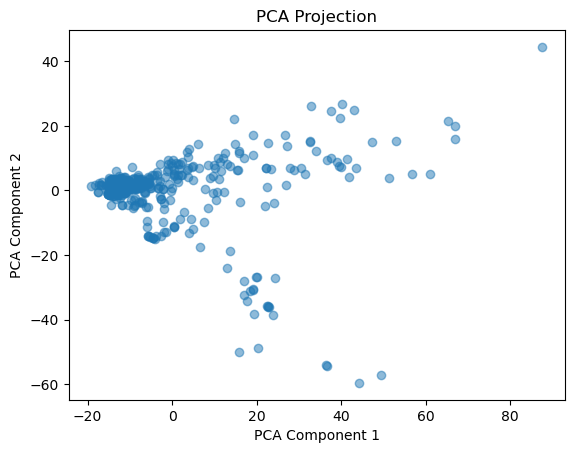

In [112]:
numerical_cols = df.iloc[:, :-5]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(numerical_cols)

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA Projection')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

The data was not normalised yet, so removing any more 'outliers' this way doesn't seem like a good idea

## Drop some collumns (correlation and variance)

Drop game names - unique for each row

In [113]:
df.shape

(382, 384)

One hot encoding - some of the columns should be perfectly correlated - pair is redundant

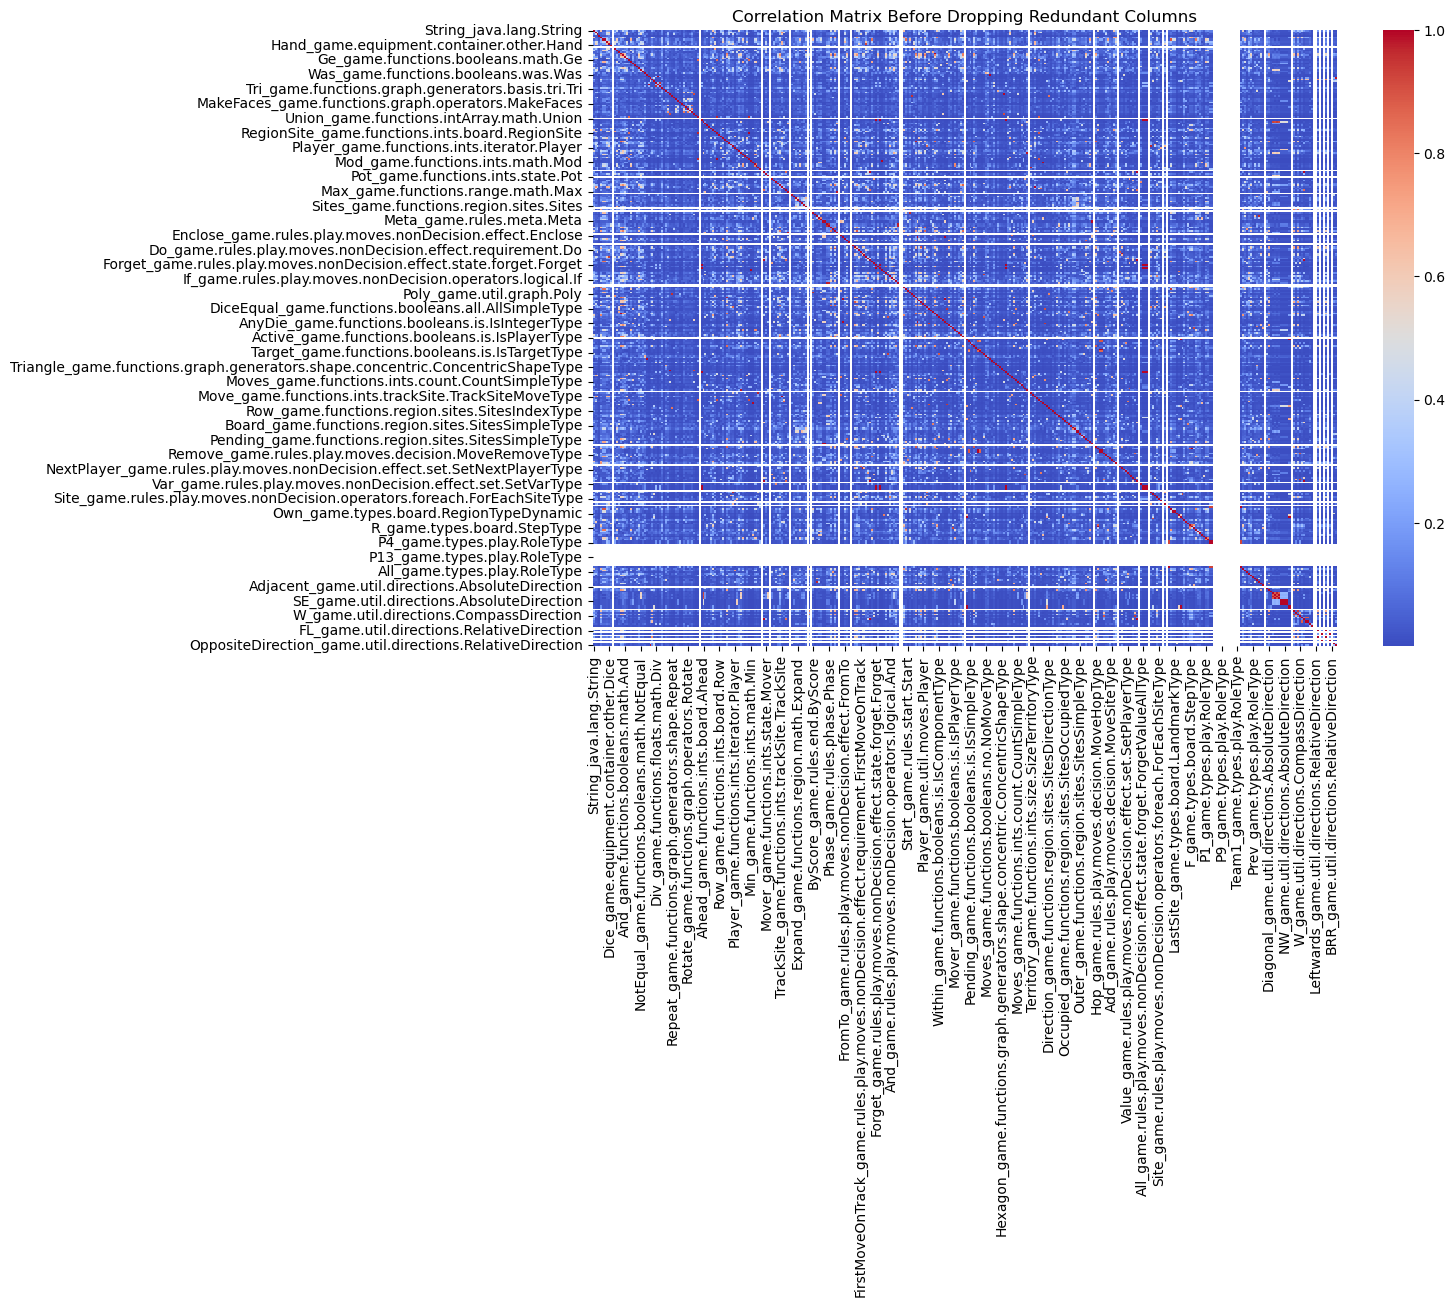

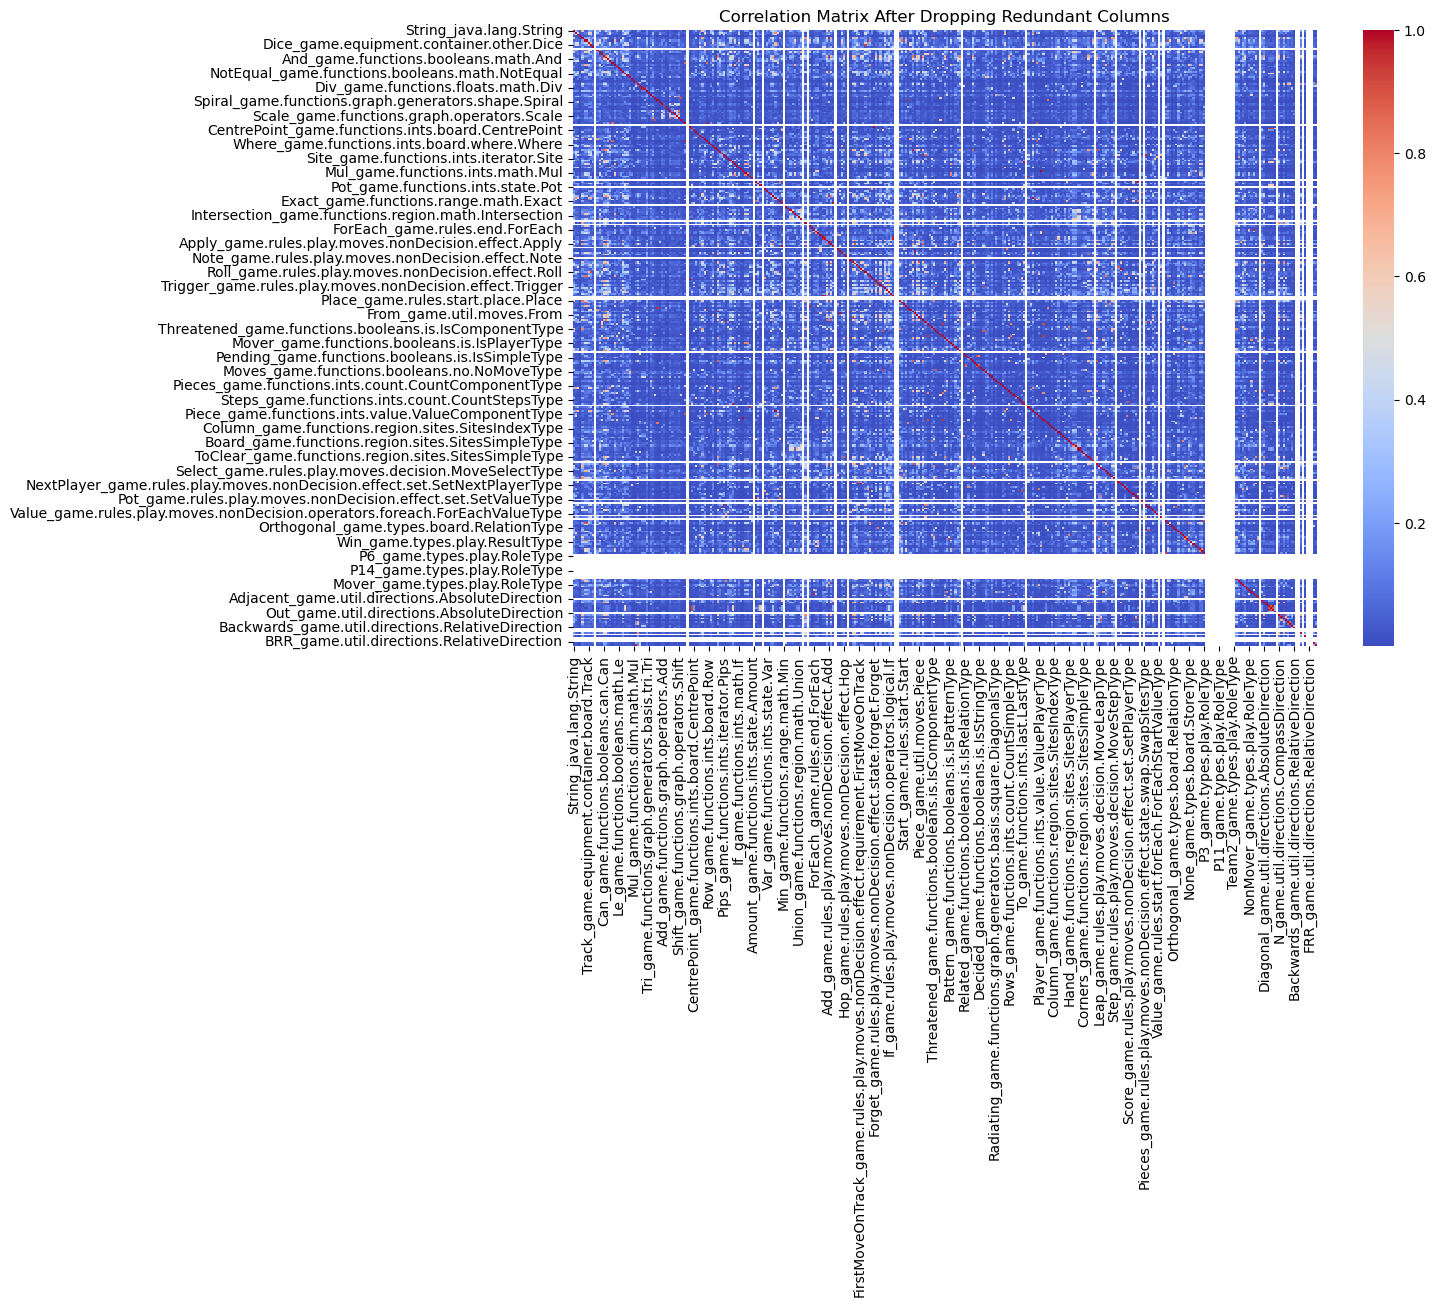

Dropped columns: ['Mul_game.functions.floats.math.Mul', 'Max_game.functions.ints.math.Max', 'No_game.rules.meta.no.No', 'Slide_game.rules.play.moves.nonDecision.effect.Slide', 'Remember_game.rules.play.moves.nonDecision.effect.state.remember.Remember', 'Step_game.rules.play.moves.nonDecision.effect.Step', 'Move_game.functions.booleans.can.CanType', 'Visited_game.functions.booleans.is.IsIntegerType', 'Pass_game.functions.booleans.was.WasType', 'Star_game.functions.graph.generators.shape.ShapeStarType', 'Remembered_game.functions.intArray.values.ValuesStringType', 'Repeat_game.rules.meta.no.NoRepeatType', 'Propose_game.rules.play.moves.decision.MoveMessageType', 'Vote_game.rules.play.moves.decision.MoveMessageType', 'All_game.rules.play.moves.nonDecision.effect.state.forget.ForgetValueAllType', 'Value_game.rules.play.moves.nonDecision.effect.state.forget.ForgetValueType', 'Value_game.rules.play.moves.nonDecision.effect.state.remember.RememberValueType', 'LastSite_game.types.board.Landmar

In [114]:
# Specify the number of label columns
label_columns = 5

# Separate features and labels
df_features = df.iloc[:, :-label_columns]
df_labels = df.iloc[:, -label_columns:]

# Compute the correlation matrix for only the features
corr_matrix = df_features.corr().abs()

# Visualize the original correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix Before Dropping Redundant Columns")
plt.show()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find the columns with perfect correlation (correlation of 1.0)
to_drop = [column for column in upper.columns if any(upper[column] == 1.0)]

# Drop the redundant columns from the features
df_features_reduced = df_features.drop(columns=to_drop)

# Concatenate the reduced features with the label columns
df_reduced = pd.concat([df_features_reduced, df_labels], axis=1)

# Compute the correlation matrix after dropping redundant columns
corr_matrix_reduced = df_features_reduced.corr().abs()

# Visualize the correlation matrix after dropping redundant columns
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_reduced, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix After Dropping Redundant Columns")
plt.show()

print(f"Dropped columns: {to_drop}")

In [115]:
df_reduced.shape

(382, 352)

Use variance threshold to drop collumns with low variation. Low variation - can't explain the labels

In [116]:

numeric_subset_df = df_reduced.select_dtypes(include='number')

variance_df = pd.DataFrame(numeric_subset_df.var(), columns=['Variance'])
sorted_variance_df = variance_df.sort_values(by='Variance', ascending=False)

columns_to_drop = sorted_variance_df[sorted_variance_df['Variance'] < 0.3].index
df_reduced = df_reduced.drop(columns=columns_to_drop)

In [117]:
df_reduced.shape

(382, 155)

## Encode categorical labels


In [118]:
category_label_encoder = LabelEncoder()
region_label_encoder = LabelEncoder()
best_agent_label_encoder = LabelEncoder()
origin_year_label_encoder = LabelEncoder()

# Fit and transform each column with its respective encoder
df_reduced['Category'] = category_label_encoder.fit_transform(df_reduced['Category'])
print("Category mapping:", dict(zip(category_label_encoder.classes_, category_label_encoder.transform(category_label_encoder.classes_))))

df_reduced['Region'] = region_label_encoder.fit_transform(df_reduced['Region'])
print("Region mapping:", dict(zip(region_label_encoder.classes_, region_label_encoder.transform(region_label_encoder.classes_))))

df_reduced['BestAgent'] = best_agent_label_encoder.fit_transform(df_reduced['BestAgent'])
print("BestAgent mapping:", dict(zip(best_agent_label_encoder.classes_, best_agent_label_encoder.transform(best_agent_label_encoder.classes_))))

df_reduced['OriginYear'] = origin_year_label_encoder.fit_transform(df_reduced['OriginYear'])
print("OriginYear mapping:", dict(zip(origin_year_label_encoder.classes_, origin_year_label_encoder.transform(origin_year_label_encoder.classes_))))

Category mapping: {'Hunt': 0, 'Puzzle': 1, 'Race': 2, 'Sow': 3, 'Space': 4, 'War': 5}
Region mapping: {'Caribbean': 0, 'Central America': 1, 'Central Asia': 2, 'Eastern Africa': 3, 'Eastern Asia': 4, 'Eastern Europe': 5, 'Micronesia': 6, 'Middle Africa': 7, 'Northern Africa': 8, 'Northern America': 9, 'Northern Asia': 10, 'Northern Europe': 11, 'Polynesia': 12, 'South America': 13, 'Southeastern Asia': 14, 'Southern Africa': 15, 'Southern Asia': 16, 'Southern Europe': 17, 'Western Africa': 18, 'Western Asia': 19, 'Western Europe': 20}
BestAgent mapping: {'Alpha-Beta': 0, 'MAST': 1, 'MC-GRAVE': 2, 'Progressive History': 3, 'Random': 4, 'UCT': 5}
OriginYear mapping: {-3300: 0, -3000: 1, -2970: 2, -2300: 3, -2200: 4, -1700: 5, -1000: 6, -180: 7, -100: 8, 250: 9, 500: 10, 600: 11, 685: 12, 694: 13, 779: 14, 790: 15, 847: 16, 1075: 17, 1100: 18, 1140: 19, 1200: 20, 1202: 21, 1221: 22, 1248: 23, 1283: 24, 1300: 25, 1352: 26, 1412: 27, 1475: 28, 1490: 29, 1496: 30, 1500: 31, 1525: 32, 1534: 3

# Predict Category 

## Data preparation

Note, in this work I intentionally avoid examining relationship between labels themselves as specified in the tasksheet. I also only use one label at a time to find the best predicting model for each label. 

Most of the labels are categorical, so to achieve the best result, for each model training I stratify data based on target label.  

### Split and import data to predict

In [119]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split( \
    df_reduced.iloc[:, :-5], \
    df_reduced['Category'], \
    stratify=df_reduced['Category'],  # Stratify based on the encoded Category column
    test_size=0.25, \
    random_state=42
)

We load unlabeld rows for prediction and remove the same collumns that we did for the trainig data

In [120]:
df_predict = pd.read_csv('work/GameData_Predictions.csv')
df_predict.shape

(5, 381)

In [121]:
columns_to_keep = [df_predict.columns[0]] + [col for col in df_predict.columns if col in X_train.columns]

# Filter df_predict to keep only the desired columns
df_predict_filtered = df_predict[columns_to_keep]

# Display the filtered DataFrame
df_predict_filtered.shape

(5, 151)

Separate the name collumn - we will need it to identify finalk predictions, but pushiong them in the learning algorithm may be problematic. Thankfully, dataframes preserve row order, so as long as we dont shufle `df_predict_filtered`, we will be able identify games.

In [122]:
predict_names = df_predict_filtered.iloc[:, 0]  # This stores the first column
df_predict_filtered = df_predict_filtered.iloc[:, 1:]
df_predict_filtered.shape

(5, 150)

### Scale

In [123]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predict_scaled = scaler.transform(df_predict_filtered)

### Reduce dimmensions

We still have too many features to feasibly try all combinations. We calculate the optimum number of principal components we could reduce our featureset to

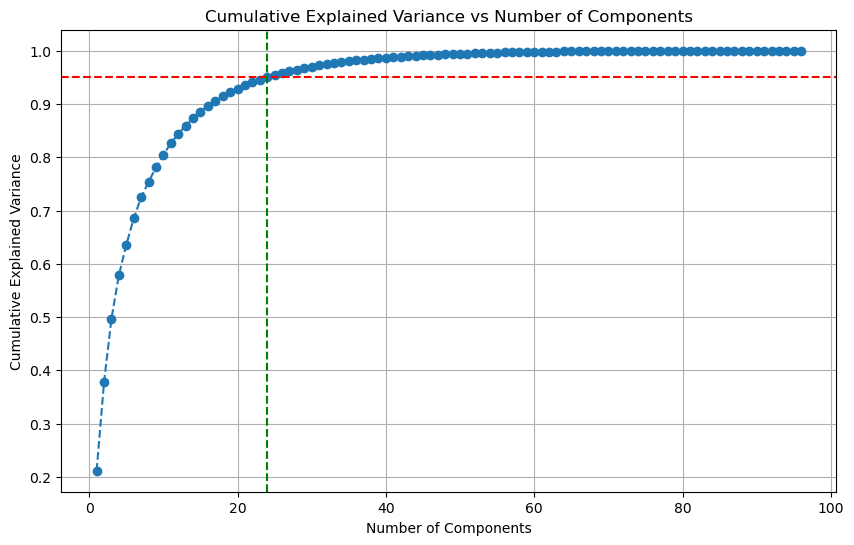

Optimal number of components to retain 95% variance: 24


In [80]:
pca = PCA()
pca.fit(X_test_scaled)

# Calculate the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Threshold line for 95%
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='g', linestyle='--')  # Optimal number of components
plt.grid()
plt.show()

# Determine the optimal number of components for 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Optimal number of components to retain 95% variance: {optimal_n_components}')

I reduce training and testing featuresets to principal components. Using the same object transformer fitted to trainign data, we scle the testing set. This way, we avoid infomration loss.

I also reduce prediction dataset to be able to apply the same model on it.

In [124]:
pca = PCA(n_components=24)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform the test data using the fitted PCA
X_test_pca = pca.transform(X_test_scaled)

predict_pca = pca.transform(predict_scaled)

Here is how some of the features look like now. After scaling and component reduction, most of them are normally distributed.

<Figure size 1200x1000 with 0 Axes>

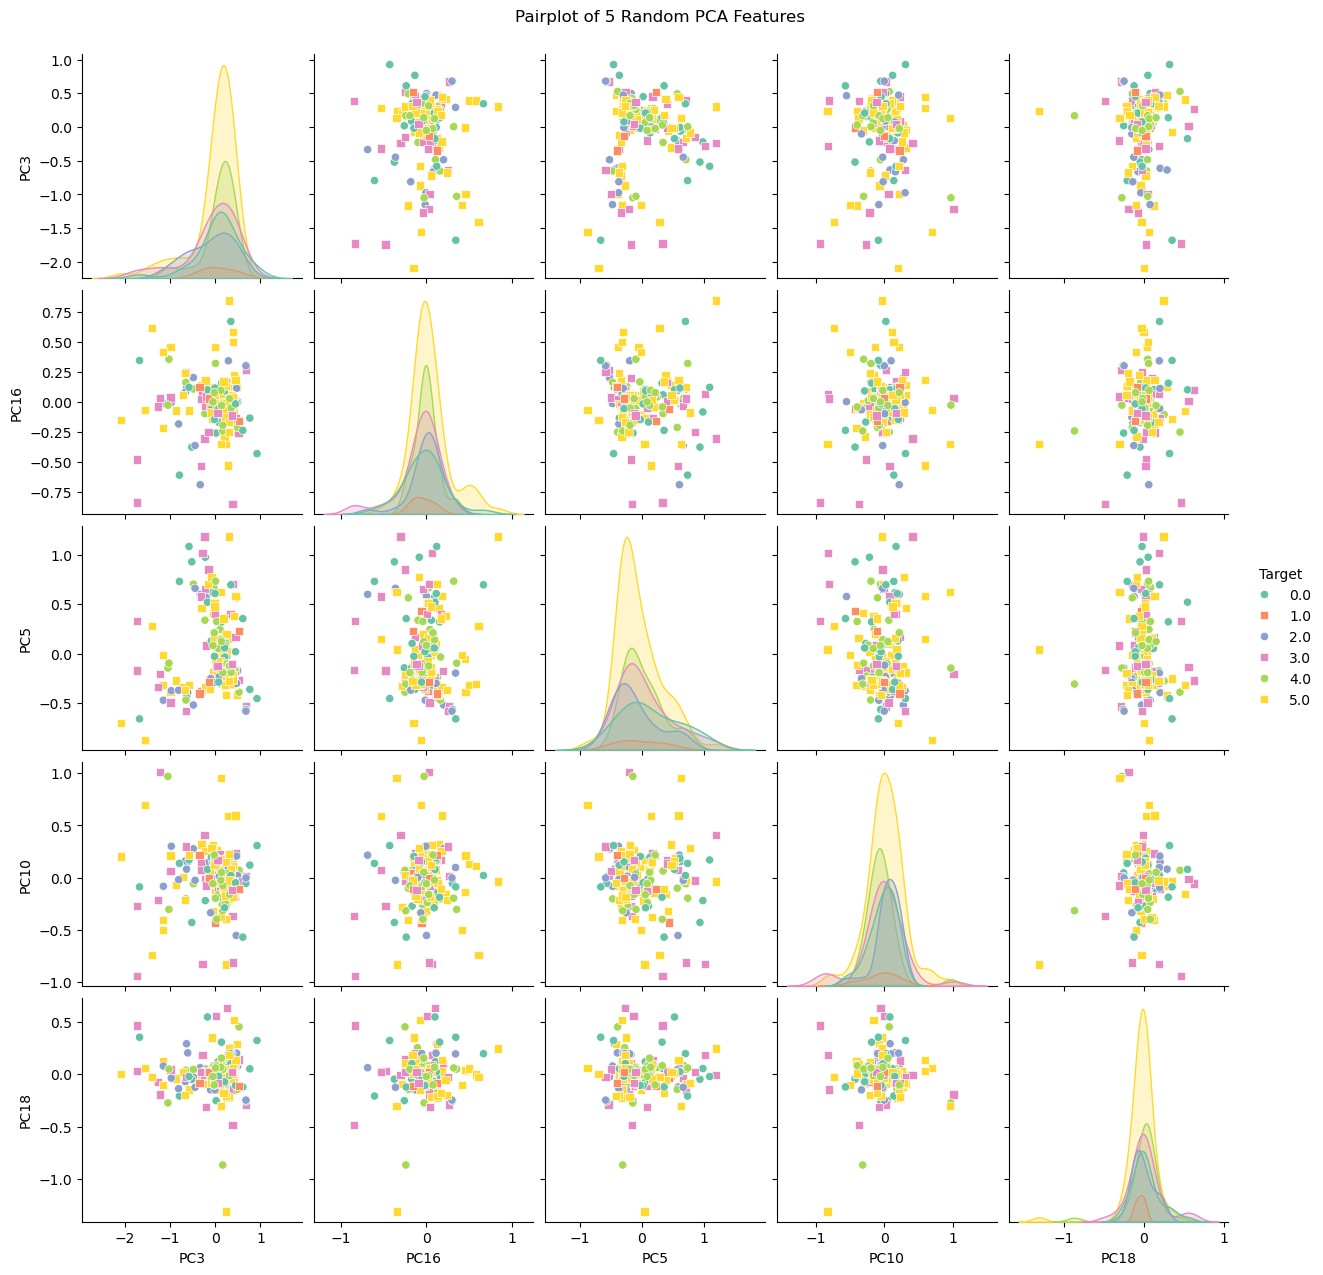

In [125]:
warnings.filterwarnings('ignore')

X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])

# Add the target variable to the DataFrame
X_train_pca_df['Target'] = y_train

# Randomly select 5 features from the PCA DataFrame
random_features = np.random.choice(X_train_pca_df.columns[:-1], size=5, replace=False)

# Create a pairplot with the selected random features and the target variable
pairplot_data = X_train_pca_df[random_features.tolist() + ['Target']]

plt.figure(figsize=(12, 10))
sns.pairplot(pairplot_data, hue='Target', markers=["o", "s"], palette='Set2')
plt.suptitle('Pairplot of 5 Random PCA Features', y=1.02)  # Adjust the title position
plt.show()

## KNN classifier with bagging ensemble

### Optimise hyperparameters

Using gridsearch with cross validation, we try fitting models to available hyperparameters untill we find the best one.

In [85]:
# Create a custom scorer for multiclass F1
f1_macro_scorer = make_scorer(f1_score, average='macro')

param_grid = {
    'n_neighbors': np.arange(1, 10),  # Specify the range for n_neighbors
    'metric': ['euclidean', 'manhattan', 'cosine', 'chebyshev']  # Include distance metrics
}

knn = KNeighborsClassifier()

# Perform grid search
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid, scoring=f1_macro_scorer, cv=kf, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters and score
best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
best_f1_score = grid_search.best_score_

print("Best k:", best_k)
print("Best Metric:", best_metric)
print("Best F1 score:", best_f1_score)

Best k: 1
Best Metric: euclidean
Best F1 score: 0.8674367672408719


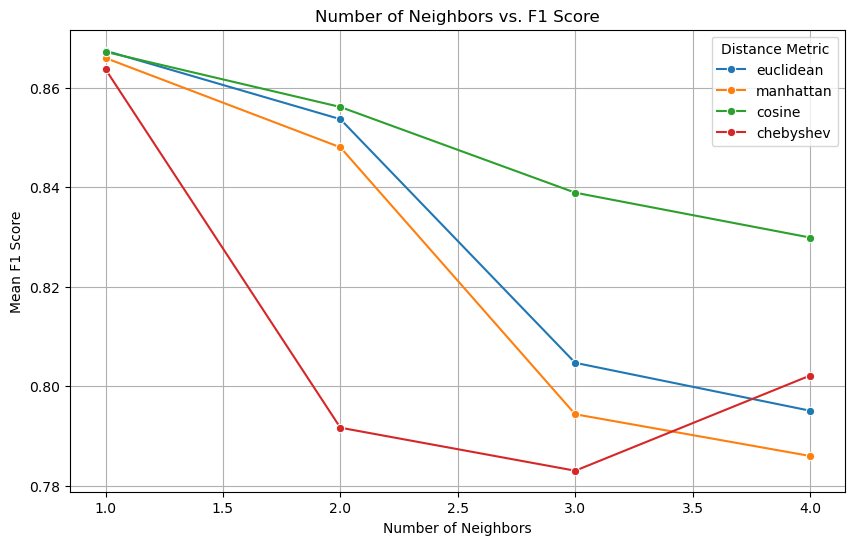


Summary Table of Metrics vs. F1 Scores:
      Metric  F1 Score
0  chebyshev  0.810117
1     cosine  0.848028
2  euclidean  0.830213
3  manhattan  0.823573


In [313]:

# Extract results for plotting
results = grid_search.cv_results_

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Plot n_neighbors vs. F1 score
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_n_neighbors', y='mean_test_score', hue='param_metric', marker='o')
plt.title('Number of Neighbors vs. F1 Score')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean F1 Score')
plt.legend(title='Distance Metric')
plt.grid()
plt.show()

# Create a summary table of metrics vs. F1 scores
summary_table = results_df[['param_metric', 'mean_test_score']]
summary_table = summary_table.rename(columns={'param_metric': 'Metric', 'mean_test_score': 'F1 Score'})
summary_table = summary_table.groupby('Metric').mean().reset_index()
print("\nSummary Table of Metrics vs. F1 Scores:")
print(summary_table)

### Training and testing

We use ensemble learning (bagging in this case) with weak models using optimised hyperparameters from the previopus step. Then, we test final model's perfomance using the test set. 

In [126]:
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

knn_Category_predictor = BaggingClassifier(
    estimator=knn,
    n_estimators=50,
    random_state=42
)

# Step 3: Train the model
knn_Category_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = knn_Category_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 6: Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='macro') 
print("F1 Score (Macro):", f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.00      0.00      0.00         2
           2       0.67      0.77      0.71        13
           3       0.95      1.00      0.97        18
           4       0.83      0.88      0.86        17
           5       0.89      0.80      0.84        30

    accuracy                           0.85        96
   macro avg       0.70      0.73      0.72        96
weighted avg       0.84      0.85      0.85        96

F1 Score (Macro): 0.7159329527750581


F1 score is computed for each class separately and then the average of these scores is taken. This approach treats all classes equally, regardless of their frequency. The warning message sometimes appears. It complains that some of the available labels were never used to calculate the metric. They were probably absent from the testing sample. 

The same approach: splitting, scaling, reducing to component analysis, searching for optimal hyperparameters, enhancing with ensamble (except for logistig regressor) is used for each model onwards. I added comments where we deviate from the process.

---
## Random Forest

### Optimise hyperparameters

In [102]:
f1_macro_scorer = make_scorer(f1_score, average='macro')

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Specify impurity measures
    'max_depth': np.arange(1, 11),  # Maximum tree depth
    'min_samples_leaf': np.arange(1, 6)  # Minimum samples per leaf
}

# Perform grid search
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring=f1_macro_scorer, cv=kf, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters and score
best_criterion = grid_search.best_params_['criterion']
best_depth = grid_search.best_params_['max_depth']
best_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_f1_score = grid_search.best_score_

print("Best Criterion:", best_criterion)
print("Best Max Depth:", best_depth)
print("Best Min Samples Leaf:", best_samples_leaf)
print("Best F1 score:", best_f1_score)

Best Criterion: entropy
Best Max Depth: 8
Best Min Samples Leaf: 3
Best F1 score: 0.7872821592465554


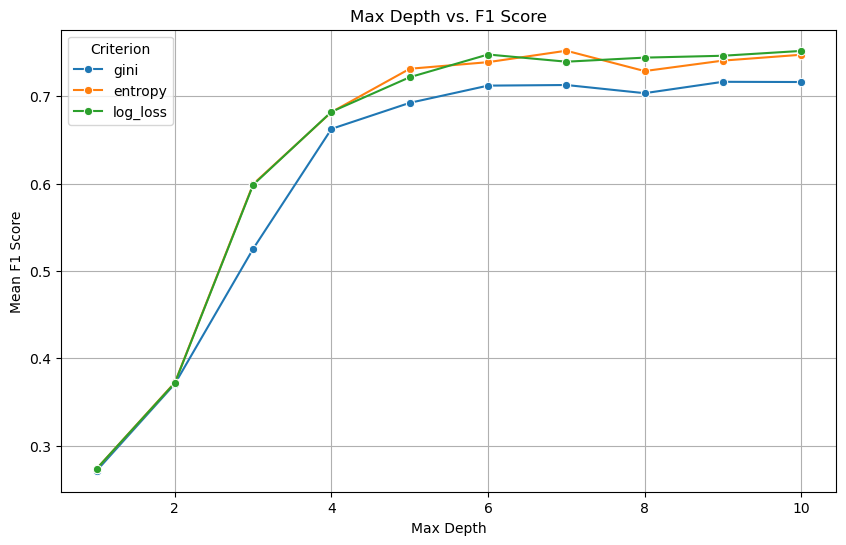


Summary Table of Criteria vs. F1 Scores:
  Criterion  F1 Score
0   entropy  0.636822
1      gini  0.608515
2  log_loss  0.637916


In [322]:
# Extract results for plotting
results = grid_search.cv_results_

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Plot max_depth vs. F1 score without confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_max_depth', y='mean_test_score', hue='param_criterion', marker='o', ci=None)
plt.title('Max Depth vs. F1 Score')
plt.xlabel('Max Depth')
plt.ylabel('Mean F1 Score')
plt.legend(title='Criterion')
plt.grid()
plt.show()

# Create a summary table of criteria vs. F1 scores
summary_table = results_df[['param_criterion', 'mean_test_score']]
summary_table = summary_table.rename(columns={'param_criterion': 'Criterion', 'mean_test_score': 'F1 Score'})
summary_table = summary_table.groupby('Criterion').mean().reset_index()
print("\nSummary Table of Criteria vs. F1 Scores:")
print(summary_table)

Here is how our decision tree looks like. For random forest multiple of them will be used.

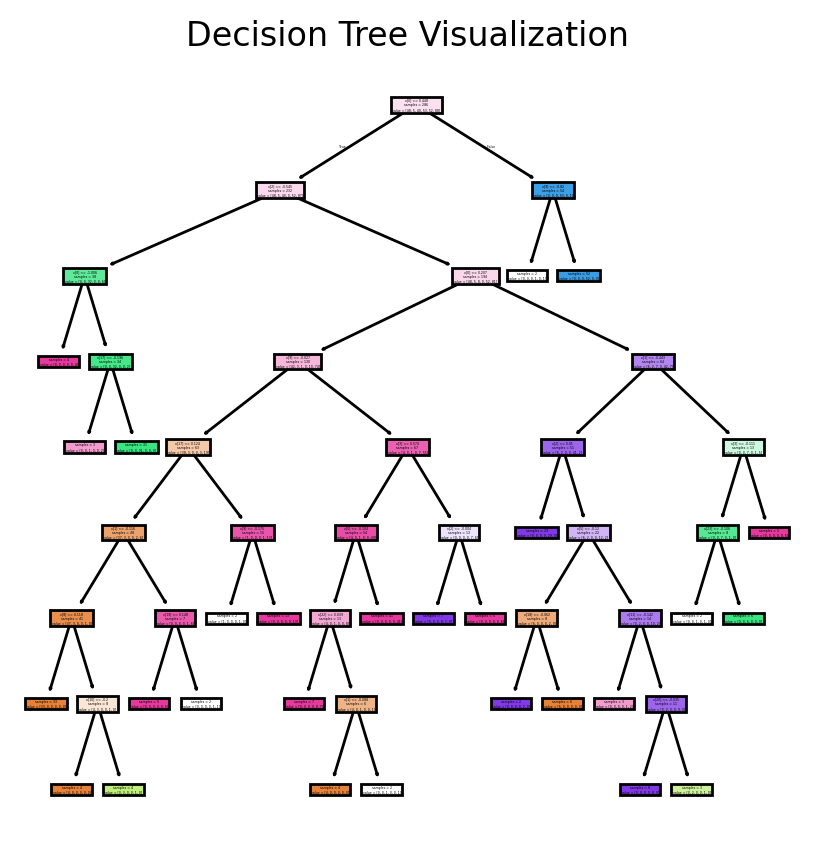

In [326]:
best_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2)
best_tree.fit(X_train_pca, y_train)

plt.figure(figsize=(5, 5), dpi=200)
plot_tree(best_tree, filled=True, 
           impurity=False,   # Remove impurity (entropy or gini)
           node_ids=False,   # Remove node ids
           proportion=False) # Do not show proportion of classes

plt.title('Decision Tree Visualization')
plt.show()

### Train and test

In [127]:
rf_Category_predictor = RandomForestClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=2,
    n_estimators=50,
    random_state=42
)

# Step 3: Train the model
rf_Category_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = rf_Category_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 6: Calculate the F1 score
Category_rf_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", Category_rf_f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.00      0.00      0.00         2
           2       0.79      0.85      0.81        13
           3       0.95      1.00      0.97        18
           4       0.94      0.88      0.91        17
           5       0.93      0.90      0.92        30

    accuracy                           0.90        96
   macro avg       0.74      0.76      0.75        96
weighted avg       0.88      0.90      0.89        96

F1 Score (Macro): 0.749080979223884


---
## Logistic regression

### Optimise hyperparameters

although the model optimisation produced a lot of warning, it still calculated the hyperparameters.

Best Penalty: l1
Best C: 61.584821106602604
Best Solver: liblinear
Best Max Iter: 100
Best F1 score: 0.8629241328090526

In [128]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization type
    'C': np.logspace(-2, 2, 20),  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers that support these penalties
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Setup cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring=f1_macro_scorer, cv=kf, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters and score
best_penalty = grid_search.best_params_['penalty']
best_C = grid_search.best_params_['C']
best_solver = grid_search.best_params_['solver']
best_max_iter = grid_search.best_params_['max_iter']
best_f1_score = grid_search.best_score_

print("Best Penalty:", best_penalty)
print("Best C:", best_C)
print("Best Solver:", best_solver)
print("Best Max Iter:", best_max_iter)
print("Best F1 score:", best_f1_score)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best Penalty: l1
Best C: 61.584821106602604
Best Solver: liblinear
Best Max Iter: 100
Best F1 score: 0.8629241328090526


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

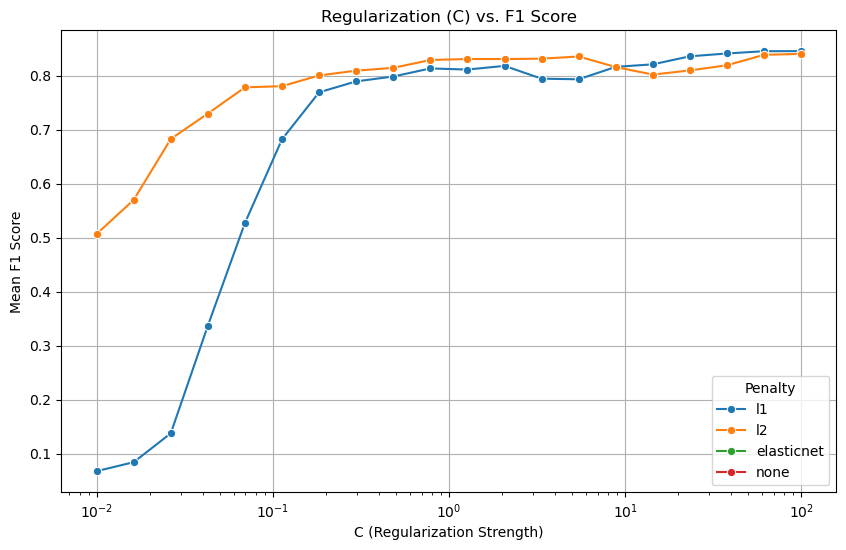


Summary Table of Penalties vs. F1 Scores:
      Penalty  F1 Score
0  elasticnet       NaN
1          l1  0.661469
2          l2  0.777863
3        none       NaN


In [336]:
results = grid_search.cv_results_

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Plot C (regularization) vs. F1 score, without confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_C', y='mean_test_score', hue='param_penalty', marker='o', ci=None)
plt.title('Regularization (C) vs. F1 Score')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Mean F1 Score')
plt.legend(title='Penalty')
plt.xscale('log')  # Set the x-axis to log scale because C is usually log-distributed
plt.grid()
plt.show()

# Create a summary table of penalties vs. F1 scores
summary_table = results_df[['param_penalty', 'mean_test_score']]
summary_table = summary_table.rename(columns={'param_penalty': 'Penalty', 'mean_test_score': 'F1 Score'})
summary_table = summary_table.groupby('Penalty').mean().reset_index()
print("\nSummary Table of Penalties vs. F1 Scores:")
print(summary_table)

### Train and test

In [129]:
lg_Category_predictor = LogisticRegression(
    penalty='l1',
    C=61.584821106602604,
    solver='liblinear',
    max_iter=100,
    random_state=42
)

# Step 2: Train the model
lg_Category_predictor.fit(X_train_pca, y_train)

# Step 3: Make predictions
y_pred = lg_Category_predictor.predict(X_test_pca)

# Step 4: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 5: Calculate the F1 score
Category_log_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", Category_log_f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       1.00      0.50      0.67         2
           2       0.86      0.92      0.89        13
           3       0.95      1.00      0.97        18
           4       1.00      0.94      0.97        17
           5       0.97      0.93      0.95        30

    accuracy                           0.95        96
   macro avg       0.95      0.88      0.90        96
weighted avg       0.95      0.95      0.95        96

F1 Score (Macro): 0.9028458350492249


## Comparison

knn f1 = 0.72

RF f1 = 0.75

LG f1 = 0.9

Logistic regression is the best model to predict the Category label. We repaet all the steps for finding the best predicting model for each label in our dataset. 

## Prediction

In [130]:
y_pred = lg_Category_predictor.predict(predict_pca)

# Step 2: Reverse the encoding for the 'Category' column
predicted_categories = category_label_encoder.inverse_transform(y_pred)

final_df = pd.DataFrame({
    'Game Name': predict_names,       # we use names that we separated in the Data preparation section       
    'Predicted Category': predicted_categories 
})

print(final_df)

                  Game Name Predicted Category
0          Main Tapak Empat               Hunt
1          Boxijn Barildaan                War
2                Provincial               Race
3  Tsoro Additional Capture                Sow
4         Marelle Quadruple              Space


---
# Predict Region

## Data Preparation

### Remove categories with vewer than 2 instances

Here, because some of the categories only have 1 instance, we can't stratify the sample. Because it is only one instace, we are very unlikely going to successfully predict its label anyway, so we remove such classes with their singular instances.

In [131]:
print(df_reduced['Region'].value_counts())

Region
16    80
3     36
17    34
18    32
11    31
10    30
14    26
8     21
4     20
9     19
19    10
5      7
7      7
2      6
20     6
13     5
0      4
12     3
1      2
6      2
15     1
Name: count, dtype: int64


There is only one recorded game from South Africa (see the section where we encoded categorical classes above)

In [136]:
class_counts = df_reduced['Region'].value_counts()
valid_classes = class_counts[class_counts >= 2].index

# Step 2: Filter the DataFrame to keep only valid classes
df_filtered = df_reduced[df_reduced['Region'].isin(valid_classes)]
print(df_filtered['Region'].value_counts())

Region
16    80
3     36
17    34
18    32
11    31
10    30
14    26
8     21
4     20
9     19
19    10
5      7
7      7
2      6
20     6
13     5
0      4
12     3
1      2
6      2
Name: count, dtype: int64


### Split

In [137]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split( \
    df_filtered.iloc[:, :-5], \
    df_filtered['Region'], \
    stratify=df_filtered['Region'],  # Stratify based on the encoded Region column
    test_size=0.25, \
    random_state=42
)

### Scale

In [138]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predict_scaled = scaler.transform(df_predict_filtered) # using the same predict dataframe that we formed in the Category section

### Reduce dimmensions

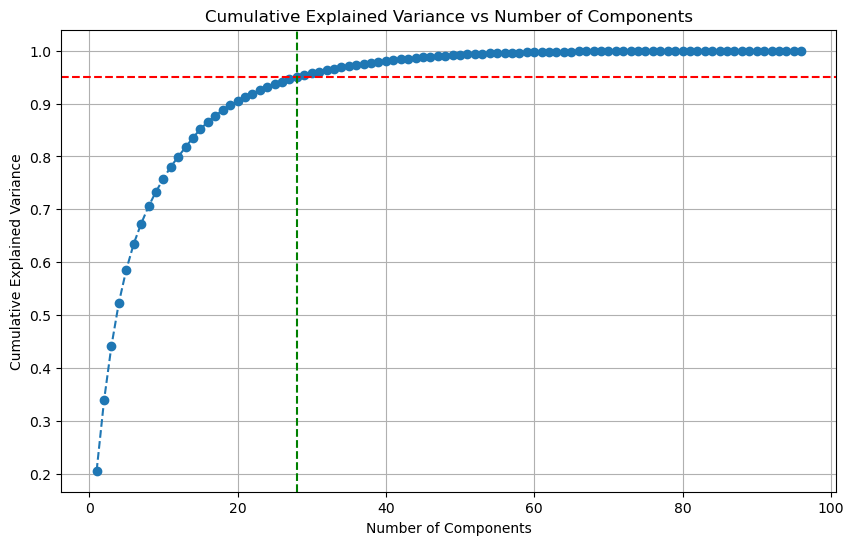

Optimal number of components to retain 95% variance: 28


In [349]:
pca = PCA()
pca.fit(X_test_scaled)

# Calculate the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Threshold line for 95%
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='g', linestyle='--')  # Optimal number of components
plt.grid()
plt.show()

# Determine the optimal number of components for 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Optimal number of components to retain 95% variance: {optimal_n_components}')

In [139]:
pca = PCA(n_components=28)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.transform(X_test_scaled)
predict_pca = pca.transform(predict_scaled)

## KNN classifier with bagging ensemble

### Optimise hyperparameters

note, usual kfold couldn't handle class imbalance with our labels (most of the games are from the same regions), so stratified kfold was used instead.

In [367]:
# Create a custom scorer for multiclass F1
f1_macro_scorer = make_scorer(f1_score, average='macro')

param_grid = {
    'n_neighbors': np.arange(1, 10),  
    'metric': ['euclidean', 'manhattan', 'cosine', 'chebyshev']  # Include distance metrics
}

knn = KNeighborsClassifier()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid, scoring=f1_macro_scorer, cv=skf, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
best_f1_score = grid_search.best_score_

print("Best k:", best_k)
print("Best Metric:", best_metric)
print("Best F1 score:", best_f1_score)

Best k: 1
Best Metric: manhattan
Best F1 score: 0.24340812533794992


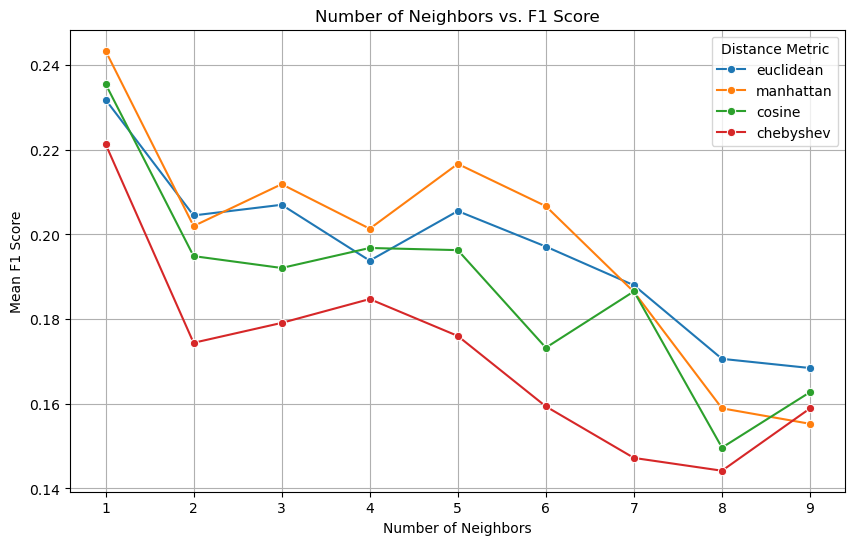


Summary Table of Metrics vs. F1 Scores:
      Metric  F1 Score
0  chebyshev  0.171712
1     cosine  0.187544
2  euclidean  0.196328
3  manhattan  0.198073


In [368]:
# Extract results for plotting
results = grid_search.cv_results_

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Plot n_neighbors vs. F1 score
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_n_neighbors', y='mean_test_score', hue='param_metric', marker='o')
plt.title('Number of Neighbors vs. F1 Score')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean F1 Score')
plt.legend(title='Distance Metric')
plt.grid()
plt.show()

# Create a summary table of metrics vs. F1 scores
summary_table = results_df[['param_metric', 'mean_test_score']]
summary_table = summary_table.rename(columns={'param_metric': 'Metric', 'mean_test_score': 'F1 Score'})
summary_table = summary_table.groupby('Metric').mean().reset_index()
print("\nSummary Table of Metrics vs. F1 Scores:")
print(summary_table)

### Training and testing

In [141]:
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

knn_Region_predictor = BaggingClassifier(
    estimator=knn,
    n_estimators=50,
    random_state=42
)

# Step 3: Train the model
knn_Region_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = knn_Region_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 6: Calculate the F1 score
Category_knn_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.50      0.33      0.40         9
           4       0.25      0.40      0.31         5
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.50      0.60      0.55         5
           9       0.40      0.40      0.40         5
          10       0.00      0.00      0.00         8
          11       0.40      0.50      0.44         8
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         7
          16       0.38      0.40      0.39        20
          17       0.75      0.33      0.46         9
          18       0.50      0.50      0.50         8
          19       0.00      0.00      0.00         3
   

The model struggles to identify labels that we have few of. It manages well enough to idenify the majority lables though.

---
## Random Forest

### Optimise hyperparameters

In [373]:
f1_macro_scorer = make_scorer(f1_score, average='macro')

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Specify impurity measures
    'max_depth': np.arange(1, 11),  # Maximum tree depth
    'min_samples_leaf': np.arange(1, 15)  # Minimum samples per leaf
}

# Perform grid search
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring=f1_macro_scorer, cv=skf, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters and score
best_criterion = grid_search.best_params_['criterion']
best_depth = grid_search.best_params_['max_depth']
best_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_f1_score = grid_search.best_score_

print("Best Criterion:", best_criterion)
print("Best Max Depth:", best_depth)
print("Best Min Samples Leaf:", best_samples_leaf)
print("Best F1 score:", best_f1_score)

Best Criterion: entropy
Best Max Depth: 8
Best Min Samples Leaf: 1
Best F1 score: 0.1896922737868132


Very bad score. We will see if using them in ensemble makes any difference

### Train and test

In [142]:
rf_Region_predictor = RandomForestClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=1,
    n_estimators=50,
    random_state=42
)

# Step 3: Train the model
rf_Region_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = rf_Region_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 6: Calculate the F1 score
Category_rf_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", Category_rf_f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.80      0.44      0.57         9
           4       0.14      0.20      0.17         5
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.67      0.40      0.50         5
           9       0.50      0.40      0.44         5
          10       0.00      0.00      0.00         8
          11       0.57      0.50      0.53         8
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         7
          16       0.33      0.65      0.43        20
          17       0.62      0.56      0.59         9
          18       0.23      0.38      0.29         8
          19       0.00      0.00      0.00         3
   

Very little improvement from putting the model into ensemble. Imbalanced classed seem problematic

---
## Logistic regression

### Optimise hyperparameters

In [375]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization type
    'C': np.logspace(-2, 2, 20),  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers that support these penalties
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Setup cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring=f1_macro_scorer, cv=skf, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters and score
best_penalty = grid_search.best_params_['penalty']
best_C = grid_search.best_params_['C']
best_solver = grid_search.best_params_['solver']
best_max_iter = grid_search.best_params_['max_iter']
best_f1_score = grid_search.best_score_

print("Best Penalty:", best_penalty)
print("Best C:", best_C)
print("Best Solver:", best_solver)
print("Best Max Iter:", best_max_iter)
print("Best F1 score:", best_f1_score)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best Penalty: l1
Best C: 8.858667904100823
Best Solver: liblinear
Best Max Iter: 100
Best F1 score: 0.1998633460505583


### Train and test

In [143]:
lg_Region_predictor = LogisticRegression(
    penalty='l1',
    C=8.858667904100823,
    solver='liblinear',
    max_iter=100,
    random_state=42
)

# Step 2: Train the model
lg_Region_predictor.fit(X_train_pca, y_train)

# Step 3: Make predictions
y_pred = lg_Region_predictor.predict(X_test_pca)

# Step 4: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 5: Calculate the F1 score
Category_log_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", Category_log_f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.57      0.44      0.50         9
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.40      0.40      0.40         5
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         8
          11       0.60      0.38      0.46         8
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.38      0.43      0.40         7
          16       0.35      0.75      0.48        20
          17       0.50      0.22      0.31         9
          18       0.25      0.38      0.30         8
          19       0.00      0.00      0.00         3
   

knn is the best predictor for Region label. All of the models suffer from imbalance in class numbers. knn's f1 score is significantly higher than the rest of them. It managed to predict the mojority classes, while rf and lg did not identify the mojority classes

## Overview

knn f1 = 0.72

FR f1 = 0.2

LG f1 = 0.16

## Prediction

In [144]:
y_pred = knn_Region_predictor.predict(predict_pca)

predicted_categories = region_label_encoder.inverse_transform(y_pred)

final_df = pd.DataFrame({
    'Game Name': predict_names,              
    'Predicted Region': predicted_categories 
})

print(final_df)

                  Game Name Predicted Region
0          Main Tapak Empat    Southern Asia
1          Boxijn Barildaan    Northern Asia
2                Provincial  Northern Europe
3  Tsoro Additional Capture   Eastern Africa
4         Marelle Quadruple     Eastern Asia


---
# Predict Best Agent

## Data Preparation

### Split

In [149]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split( \
    df_reduced.iloc[:, :-5], \
    df_reduced['BestAgent'], \
    stratify=df_reduced['BestAgent'], 
    test_size=0.25, \
    random_state=42
)

### Scale

In [150]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predict_scaled = scaler.transform(df_predict_filtered)

### Reduce dimensions

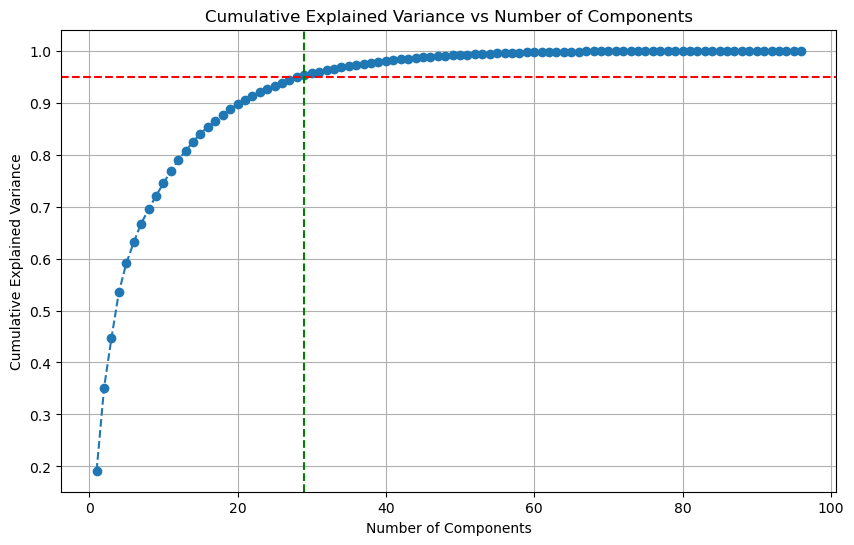

Optimal number of components to retain 95% variance: 29


In [379]:
pca = PCA()
pca.fit(X_test_scaled)

# Calculate the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Threshold line for 95%
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='g', linestyle='--')  # Optimal number of components
plt.grid()
plt.show()

# Determine the optimal number of components for 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Optimal number of components to retain 95% variance: {optimal_n_components}')

In [151]:
pca = PCA(n_components=29)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform the test data using the fitted PCA
X_test_pca = pca.transform(X_test_scaled)
predict_pca = pca.transform(predict_scaled)

## KNN classifier with bagging ensemble

### Optimise hyperparameters

In [381]:
f1_macro_scorer = make_scorer(f1_score, average='macro')

param_grid = {
    'n_neighbors': np.arange(1, 10),  # Specify the range for n_neighbors
    'metric': ['euclidean', 'manhattan', 'cosine', 'chebyshev']  # Include distance metrics
}

knn = KNeighborsClassifier()

# Perform grid search
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid, scoring=f1_macro_scorer, cv=kf, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters and score
best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
best_f1_score = grid_search.best_score_

print("Best k:", best_k)
print("Best Metric:", best_metric)
print("Best F1 score:", best_f1_score)

Best k: 1
Best Metric: chebyshev
Best F1 score: 0.3415488099134221


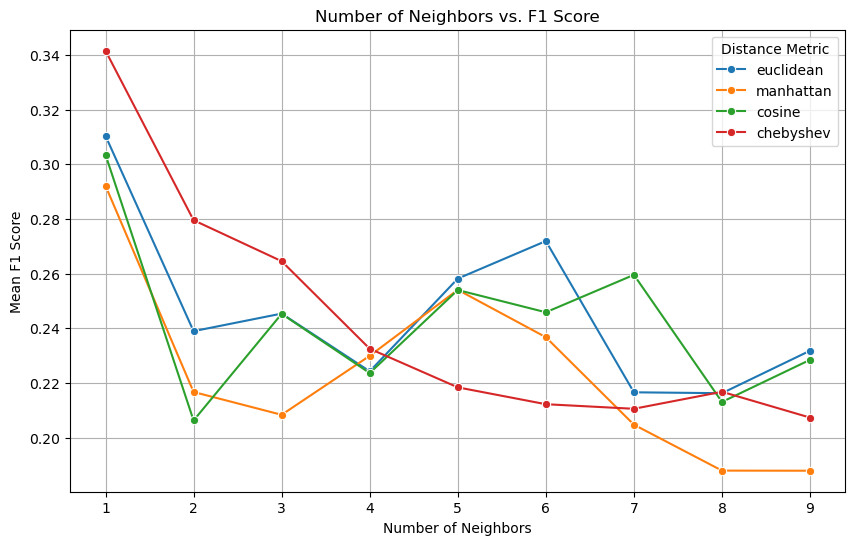


Summary Table of Metrics vs. F1 Scores:
      Metric  F1 Score
0  chebyshev  0.242592
1     cosine  0.242168
2  euclidean  0.245958
3  manhattan  0.224263


In [382]:
# Extract results for plotting
results = grid_search.cv_results_

# Create a DataFrame for the results
results_df = pd.DataFrame(results)

# Plot n_neighbors vs. F1 score
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='param_n_neighbors', y='mean_test_score', hue='param_metric', marker='o')
plt.title('Number of Neighbors vs. F1 Score')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean F1 Score')
plt.legend(title='Distance Metric')
plt.grid()
plt.show()

# Create a summary table of metrics vs. F1 scores
summary_table = results_df[['param_metric', 'mean_test_score']]
summary_table = summary_table.rename(columns={'param_metric': 'Metric', 'mean_test_score': 'F1 Score'})
summary_table = summary_table.groupby('Metric').mean().reset_index()
print("\nSummary Table of Metrics vs. F1 Scores:")
print(summary_table)

### Train and test

In [152]:
knn = KNeighborsClassifier(n_neighbors=1, metric='chebyshev')

knn_Agent_predictor = BaggingClassifier(
    estimator=knn,
    n_estimators=50,
    random_state=42
)

# Step 3: Train the model
knn_Agent_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = knn_Agent_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 6: Calculate the F1 score
Category_knn_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67        55
           1       0.07      0.07      0.07        14
           2       0.00      0.00      0.00         2
           3       0.50      0.44      0.47         9
           4       0.00      0.00      0.00         3
           5       0.13      0.15      0.14        13

    accuracy                           0.46        96
   macro avg       0.23      0.22      0.23        96
weighted avg       0.46      0.46      0.46        96

F1 Score (Macro): 0.7159329527750581


In this case, model perfomance significantly imrpved from being put into an ensemble.

## Random Forest

### Optimise hyperparameters

In [384]:
f1_macro_scorer = make_scorer(f1_score, average='macro')

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Specify impurity measures
    'max_depth': np.arange(1, 11),  # Maximum tree depth
    'min_samples_leaf': np.arange(1, 6)  # Minimum samples per leaf
}

# Perform grid search
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring=f1_macro_scorer, cv=kf, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters and score
best_criterion = grid_search.best_params_['criterion']
best_depth = grid_search.best_params_['max_depth']
best_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_f1_score = grid_search.best_score_

print("Best Criterion:", best_criterion)
print("Best Max Depth:", best_depth)
print("Best Min Samples Leaf:", best_samples_leaf)
print("Best F1 score:", best_f1_score)

Best Criterion: gini
Best Max Depth: 9
Best Min Samples Leaf: 2
Best F1 score: 0.2793371797860007


### Train and test

In [153]:
rf_Agent_predictor = RandomForestClassifier(
    criterion='gini',
    max_depth=9,
    min_samples_leaf=2,
    n_estimators=50,
    random_state=42
)

# Step 3: Train the model
rf_Agent_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = rf_Agent_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 6: Calculate the F1 score
Category_rf_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", Category_rf_f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.87      0.72        55
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00         2
           3       0.50      0.44      0.47         9
           4       0.00      0.00      0.00         3
           5       0.20      0.15      0.17        13

    accuracy                           0.56        96
   macro avg       0.22      0.25      0.23        96
weighted avg       0.43      0.56      0.48        96

F1 Score (Macro): 0.22771763167509565


## Logistic Regression

### Optimise hyperparameters

In [386]:
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization type
    'C': np.logspace(-2, 2, 20),  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'],  # Solvers that support these penalties
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Setup cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring=f1_macro_scorer, cv=kf, n_jobs=-1)
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters and score
best_penalty = grid_search.best_params_['penalty']
best_C = grid_search.best_params_['C']
best_solver = grid_search.best_params_['solver']
best_max_iter = grid_search.best_params_['max_iter']
best_f1_score = grid_search.best_score_

print("Best Penalty:", best_penalty)
print("Best C:", best_C)
print("Best Solver:", best_solver)
print("Best Max Iter:", best_max_iter)
print("Best F1 score:", best_f1_score)

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best Penalty: l1
Best C: 5.455594781168514
Best Solver: saga
Best Max Iter: 300
Best F1 score: 0.303010798716681


### Train and test

In [154]:
lg_Agent_predictor = LogisticRegression(
    penalty='l1',
    C=5.455594781168514,
    solver='saga',
    max_iter=300,
    random_state=42
)

# Step 2: Train the model
lg_Agent_predictor.fit(X_train_pca, y_train)

# Step 3: Make predictions
y_pred = lg_Agent_predictor.predict(X_test_pca)

# Step 4: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 5: Calculate the F1 score
Category_log_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", Category_log_f1)

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.91      0.81        55
           1       0.46      0.43      0.44        14
           2       0.00      0.00      0.00         2
           3       0.50      0.56      0.53         9
           4       0.00      0.00      0.00         3
           5       0.25      0.08      0.12        13

    accuracy                           0.65        96
   macro avg       0.32      0.33      0.32        96
weighted avg       0.56      0.65      0.59        96

F1 Score (Macro): 0.3158098176074806


## Overview

LR f1 = 0.32 

RF f1 = 0.23 

KNN f1 = 0.72

Interestingly, knn significalty improved from being put into an ensamble, unlike rf. This label is also quite imbalanced. From data overview section we learned that Alpha-Beta agent class has 234 instances.

Just like with the Region, knn works fine with imbalanced classes by guessing the major classes, while rf struggles to put appropriate rule in the top of its trees. It could be the case that rf doesn't work well with pca reduced data. It is something worth exploring more in  the future.

## Prediction

In [155]:
y_pred = knn_Agent_predictor.predict(predict_pca)

predicted_categories = best_agent_label_encoder.inverse_transform(y_pred)

final_df = pd.DataFrame({
    'Game Name': predict_names,       # we use names that we separated in the Data preparation section       
    'Predicted best Agent': predicted_categories 
})

print(final_df)

                  Game Name Predicted best Agent
0          Main Tapak Empat           Alpha-Beta
1          Boxijn Barildaan           Alpha-Beta
2                Provincial           Alpha-Beta
3  Tsoro Additional Capture           Alpha-Beta
4         Marelle Quadruple           Alpha-Beta


---
# Predicting year

## Data Preparation

### Remove categories with vewer than 2 instances

In [166]:
class_counts = df_reduced['OriginYear'].value_counts()
valid_classes = class_counts[class_counts >= 2].index

# Step 2: Filter the DataFrame to keep only valid classes
df_filtered = df_reduced[df_reduced['OriginYear'].isin(valid_classes)]
print(df_filtered['OriginYear'].value_counts())

OriginYear
136    21
134    16
132    13
101    12
123    11
       ..
116     2
131     2
59      2
22      2
135     2
Name: count, Length: 63, dtype: int64


### Split

In [167]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split( \
    df_filtered.iloc[:, :-5], \
    df_filtered['OriginYear'], \
    stratify=df_filtered['OriginYear'], 
    test_size=0.25, \
    random_state=42
)

### Scale

minmax scaler seems to be safer option given that most of the data is binary

In [168]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predict_scaled = scaler.transform(df_predict_filtered)

### Reduce dimensions

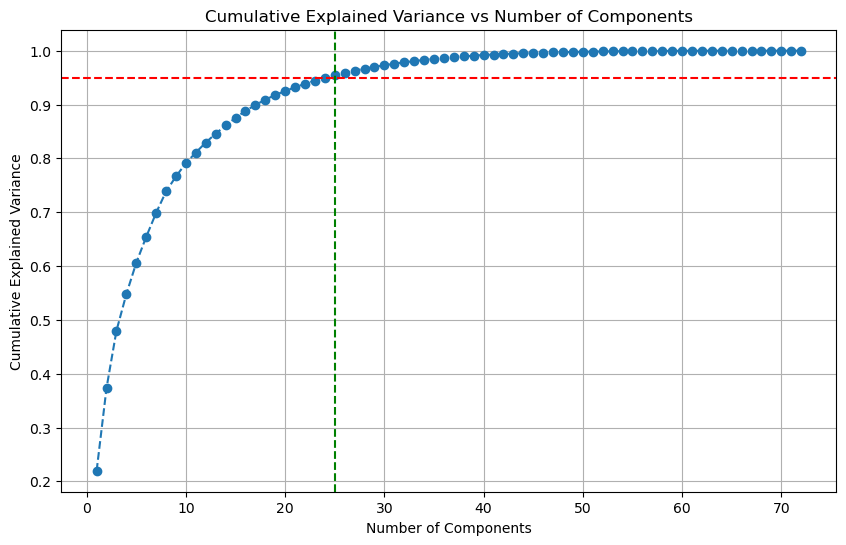

Optimal number of components to retain 95% variance: 25


In [159]:
pca = PCA()
pca.fit(X_test_scaled)

# Calculate the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Threshold line for 95%
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='g', linestyle='--')  # Optimal number of components
plt.grid()
plt.show()

# Determine the optimal number of components for 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Optimal number of components to retain 95% variance: {optimal_n_components}')

In [169]:
pca = PCA(n_components=25)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.transform(X_test_scaled)
predict_pca = pca.transform(predict_scaled)

## KNN Classifier with bagging ensemble

### Optimise hyperparameters

Grid search, even the stratified one, could not handle this label. There are too many categories. The label is skewed towards the more recent years as well. 

So I implemented grid search manually here.

In [171]:
# Define the parameter grid
param_grid = {
    'n_neighbors': np.arange(1, 10),
    'metric': ['euclidean', 'manhattan', 'cosine', 'chebyshev']
}

# Create StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store the best F1 score and corresponding parameters
best_f1_score = 0
best_params = {}

# Loop over each combination of hyperparameters
for n_neighbors, metric in product(param_grid['n_neighbors'], param_grid['metric']):
    f1_scores = []  # List to store F1 scores for this parameter combination

    # Perform cross-validation
    for train_index, test_index in skf.split(X_train_pca, y_train):
        X_train_fold, X_test_fold = X_train_pca[train_index], X_train_pca[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]  # Ensure to use .iloc

        # Train the KNN model
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        knn.fit(X_train_fold, y_train_fold)

        # Predict and calculate F1 score
        y_pred = knn.predict(X_test_fold)
        f1 = f1_score(y_test_fold, y_pred, average='macro')
        f1_scores.append(f1)

    # Calculate the average F1 score for this parameter combination
    avg_f1_score = np.mean(f1_scores)

    # Update the best parameters if the current F1 score is better
    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        best_params = {'n_neighbors': n_neighbors, 'metric': metric}

# Output the best parameters and score
print("Best k:", best_params['n_neighbors'])
print("Best Metric:", best_params['metric'])
print("Best F1 score:", best_f1_score)

Best k: 1
Best Metric: manhattan
Best F1 score: 0.13194463294463293


### Train and test

In [173]:
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')

knn_Year_predictor = BaggingClassifier(
    estimator=knn,
    n_estimators=50,
    random_state=42
)

# Step 3: Train the model
knn_Year_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = knn_Year_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 6: Calculate the F1 score
Category_knn_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", f1)

Classification Report:
               precision    recall  f1-score   support

          11       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       0.60      1.00      0.75         3
          25       0.50      1.00      0.67         1
          39       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         2
          49       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         1
          55       1.00      1.00      1.00         1
          59       0.00      0.00      0.00         0
          61       0.00      0.00      0.00         1
          63       0.00      0.00      0.00         1
          72       0.00      0.00      0.00         1
          75       0.00      0.00      0.00         1
          83       0.00      0.00      0.00         1
   

## Random Forest

### Optimise hyperparameters

In [431]:
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Specify impurity measures
    'max_depth': np.arange(1, 11),  # Maximum tree depth
    'min_samples_leaf': np.arange(1, 15)  # Minimum samples per leaf
}

# Create StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store the best F1 score and corresponding parameters
best_f1_score = 0
best_params = {}

# Loop over each combination of hyperparameters
for criterion, max_depth, min_samples_leaf in product(param_grid['criterion'], param_grid['max_depth'], param_grid['min_samples_leaf']):
    f1_scores = []  # List to store F1 scores for this parameter combination

    # Perform cross-validation
    for train_index, test_index in skf.split(X_train_pca, y_train):
        X_train_fold, X_test_fold = X_train_pca[train_index], X_train_pca[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]  # Ensure to use .iloc

        # Train the Decision Tree model
        dt = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        dt.fit(X_train_fold, y_train_fold)

        # Predict and calculate F1 score
        y_pred = dt.predict(X_test_fold)
        f1 = f1_score(y_test_fold, y_pred, average='macro')
        f1_scores.append(f1)

    # Calculate the average F1 score for this parameter combination
    avg_f1_score = np.mean(f1_scores)

    # Update the best parameters if the current F1 score is better
    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        best_params = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

# Output the best parameters and score
print("Best Criterion:", best_params['criterion'])
print("Best Max Depth:", best_params['max_depth'])
print("Best Min Samples Leaf:", best_params['min_samples_leaf'])
print("Best F1 score:", best_f1_score)

Best Criterion: gini
Best Max Depth: 10
Best Min Samples Leaf: 1
Best F1 score: 0.08267081608545022


### Train and test

In [174]:
rf_Year_predictor = RandomForestClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_leaf=1,
    n_estimators=50,
    random_state=42
)

# Step 3: Train the model
rf_Year_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = rf_Year_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 6: Calculate the F1 score
Category_rf_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", Category_rf_f1)

Classification Report:
               precision    recall  f1-score   support

          11       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       0.75      1.00      0.86         3
          25       0.50      1.00      0.67         1
          39       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         2
          49       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         1
          55       1.00      1.00      1.00         1
          59       0.00      0.00      0.00         0
          61       0.00      0.00      0.00         1
          63       0.00      0.00      0.00         1
          72       0.00      0.00      0.00         1
          75       0.00      0.00      0.00         1
          83       0.00      0.00      0.00         1
   

## Logistic Regression

### Optimise hyperparameters

In [437]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'C': np.logspace(-2, 2, 20),  # Inverse of regularization strength
    'solver': ['saga'],  # Only saga supports elasticnet
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Create StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store the best F1 score and corresponding parameters
best_f1_score = 0
best_params = {}

# Loop over each combination of hyperparameters
for penalty, C, solver, max_iter in product(param_grid['penalty'], param_grid['C'], param_grid['solver'], param_grid['max_iter']):
    f1_scores = []  # List to store F1 scores for this parameter combination

    # Perform cross-validation
    for train_index, test_index in skf.split(X_train_pca, y_train):
        X_train_fold, X_test_fold = X_train_pca[train_index], X_train_pca[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]  # Ensure to use .iloc

        # Train the Logistic Regression model
        if penalty == 'elasticnet':
            lr = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter, l1_ratio=0.5)  # Set l1_ratio for elasticnet
        else:
            lr = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=max_iter)

        lr.fit(X_train_fold, y_train_fold)

        # Predict and calculate F1 score
        y_pred = lr.predict(X_test_fold)
        f1 = f1_score(y_test_fold, y_pred, average='macro')
        f1_scores.append(f1)

    # Calculate the average F1 score for this parameter combination
    avg_f1_score = np.mean(f1_scores)

    # Update the best parameters if the current F1 score is better
    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        best_params = {'penalty': penalty, 'C': C, 'solver': solver, 'max_iter': max_iter}

# Output the best parameters and score
print("Best Penalty:", best_params['penalty'])
print("Best C:", best_params['C'])
print("Best Solver:", best_params['solver'])
print("Best Max Iterations:", best_params['max_iter'])
print("Best F1 Score:", best_f1_score)

Best Penalty: l2
Best C: 61.584821106602604
Best Solver: saga
Best Max Iterations: 300
Best F1 Score: 0.1277388252998009


### Train and test

In [175]:
lg_Year_predictor = LogisticRegression(
    penalty='l2',
    C=61.584821106602604,
    solver='saga',
    max_iter=300,
    random_state=42
)

# Step 2: Train the model
lg_Year_predictor.fit(X_train_pca, y_train)

# Step 3: Make predictions
y_pred = lg_Year_predictor.predict(X_test_pca)

# Step 4: Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print classification report
print("Classification Report:\n", class_report)

# Step 5: Calculate the F1 score
Category_log_f1 = f1_score(y_test, y_pred, average='macro')  # or 'weighted' based on your preference
print("F1 Score (Macro):", Category_log_f1)

Classification Report:
               precision    recall  f1-score   support

          11       0.00      0.00      0.00         0
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       1.00      1.00      1.00         3
          25       0.50      1.00      0.67         1
          39       0.00      0.00      0.00         1
          42       0.00      0.00      0.00         2
          49       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         1
          55       0.33      1.00      0.50         1
          59       0.00      0.00      0.00         0
          61       0.00      0.00      0.00         1
          63       0.00      0.00      0.00         1
          71       0.00      0.00      0.00         0
          72       0.00      0.00      0.00         1
          75       0.00      0.00      0.00         1
   

## Overview

knn f1 = 0.04

RF f1 = 0.12

LG f1 = 0.09

Surprisingly, this time knn coudn't predict majority classes. I think there were too many other classes that confused it.

## Predict

In [176]:
y_pred = rf_Year_predictor.predict(predict_pca)

predicted_categories = origin_year_label_encoder.inverse_transform(y_pred)

final_df = pd.DataFrame({
    'Game Name': predict_names,       # we use names that we separated in the Data preparation section       
    'Predicted Origin Year': predicted_categories 
})

print(final_df)

                  Game Name  Predicted Origin Year
0          Main Tapak Empat                   1935
1          Boxijn Barildaan                   1963
2                Provincial                   1300
3  Tsoro Additional Capture                   1964
4         Marelle Quadruple                   1694


---
# Predicting UCT

## Data Preparation

### Split

Here I don't stratify our split because the label is a countinous variable

In [180]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split( \
    df_reduced.iloc[:, :-5], \
    df_reduced['UCT'], \
    test_size=0.25, \
    random_state=42
)

### Scale

In [181]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predict_scaled = scaler.transform(df_predict_filtered)

### Reduce dimensions

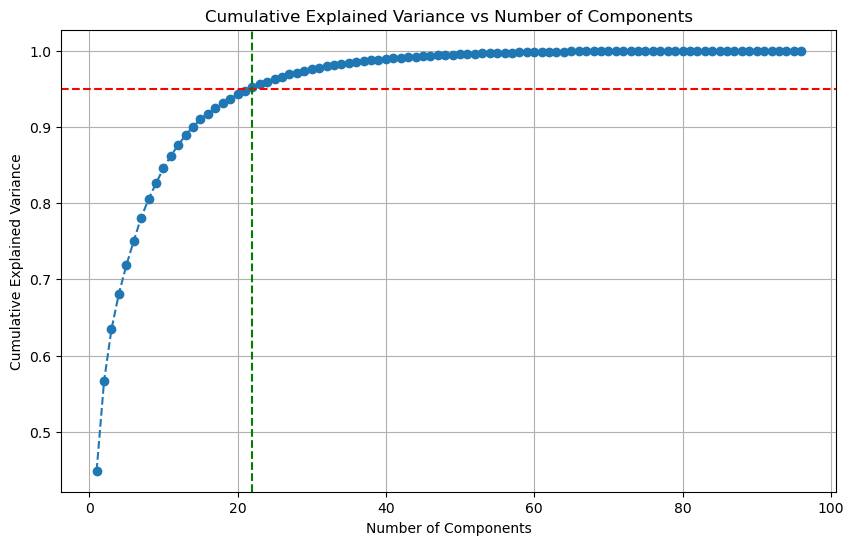

Optimal number of components to retain 95% variance: 22


In [18]:
pca = PCA()
pca.fit(X_test_scaled)

# Calculate the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--')  # Threshold line for 95%
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='g', linestyle='--')  # Optimal number of components
plt.grid()
plt.show()

# Determine the optimal number of components for 95% variance
optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Optimal number of components to retain 95% variance: {optimal_n_components}')

In [182]:
pca = PCA(n_components=22)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.transform(X_test_scaled)
predict_pca = pca.transform(predict_scaled)

## KNN Regressor with bagging ensemble

### Optimise hyperparameters

For contrinous variable UCT, I use Mean Square Error (MSE) and coefficient of determination to measure models' predictive perfomance

In [20]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Lower is better for MSE
r2_scorer = make_scorer(r2_score)  # Higher is better for R²

param_grid = {
    'n_neighbors': np.arange(1, 10),  # Specify the range for n_neighbors
    'metric': ['euclidean', 'manhattan', 'cosine', 'chebyshev']  # Include distance metrics
}

knn = KNeighborsRegressor()

# Perform grid search for both MSE and R² as scoring metrics
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV allows only one scoring metric, so we use `refit='r2'` to choose the best model by R²
grid_search = GridSearchCV(
    knn,
    param_grid,
    scoring={'MSE': mse_scorer, 'R2': r2_scorer},
    refit='R2',  # The best model will be selected based on R²
    cv=kf,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters
best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
best_mse = -grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_]  # Negate MSE
best_r2 = grid_search.best_score_  # This is the best R² score since refit='R2'

print("Best k:", best_k)
print("Best Metric:", best_metric)
print("Best MSE:", best_mse)
print("Best R² score:", best_r2)

Best k: 5
Best Metric: euclidean
Best MSE: 142.9257583002032
Best R² score: 0.23066767575453923


### Train and test

In [183]:
knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')

# Step 2: Initialize Bagging with KNeighborsRegressor as the base estimator
knn_UCT_predictor = BaggingRegressor(
    estimator=knn,
    n_estimators=50,
    random_state=42
)

# Step 3: Train the model
knn_UCT_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = knn_UCT_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R2 Score:", r2)

Mean Squared Error (MSE): 145.4695999588426
R2 Score: 0.2235060399692067


## Random Forest

### Optimise hyperparameters

In [22]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Lower is better for MSE
r2_scorer = make_scorer(r2_score)  # Higher is better for R²

# Parameter grid for DecisionTreeRegressor
param_grid = {
    'max_depth': np.arange(1, 20),  # Range of tree depths
    'min_samples_split': np.arange(2, 10)  # Minimum samples required to split
}

tree = DecisionTreeRegressor()

# Perform grid search for both MSE and R² as scoring metrics
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV allows only one scoring metric, so we use `refit='R2'` to choose the best model by R²
grid_search = GridSearchCV(
    tree,
    param_grid,
    scoring={'MSE': mse_scorer, 'R2': r2_scorer},
    refit='R2',  # The best model will be selected based on R²
    cv=kf,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_pca, y_train)

# Extract the best parameters
best_depth = grid_search.best_params_['max_depth']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_mse = -grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_]  # Negate MSE
best_r2 = grid_search.best_score_  # This is the best R² score since refit='R2'

print("Best Max Depth:", best_depth)
print("Best Min Samples Split:", best_min_samples_split)
print("Best MSE:", best_mse)
print("Best R² score:", best_r2)

Best Max Depth: 2
Best Min Samples Split: 2
Best MSE: 182.65590468123074
Best R² score: 0.026576618461491307


### Train and test

In [184]:
rf_UCT_predictor = RandomForestRegressor(  # Use RandomForestClassifier if doing classification
    max_depth=2,                     # Set the maximum depth
    min_samples_split=2,             # Set the minimum samples required to split an internal node
    n_estimators=50,                 # Number of trees
    random_state=42                   # For reproducibility
)

# Step 2: Train the model
rf_UCT_predictor.fit(X_train_pca, y_train)

# Step 3: Make predictions
y_pred = rf_UCT_predictor.predict(X_test_pca)

# Step 4: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 158.5964058031315
R² Score: 0.15343720458730492


## Linear Regression with bagging ensemble

### Optimise hyperparameters

For some reason, regularisation hyperparameters are not implemented as LinearRegression's class parameters, but as separate classes. So I had to implement this bit separatly.

In [28]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # Lower is better for MSE
r2_scorer = make_scorer(r2_score)  # Higher is better for R²

# Define the hyperparameters grid for each model

# Ridge hyperparameters
ridge_param_grid = {
    'alpha': np.logspace(-2, 2, 20),  # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'sag', 'saga', 'lsqr'],  # Solvers available for Ridge
    'fit_intercept': [True, False],  # Whether to calculate the intercept
}

# Lasso hyperparameters
lasso_param_grid = {
    'alpha': np.logspace(-2, 2, 20),  # Regularization strength
    'fit_intercept': [True, False],  # Whether to calculate the intercept
}

# ElasticNet hyperparameters
elasticnet_param_grid = {
    'alpha': np.logspace(-2, 2, 20),  # Regularization strength
    'l1_ratio': np.linspace(0, 1, 10),  # Mix ratio of L1 and L2
    'fit_intercept': [True, False],  # Whether to calculate the intercept
}

# Setup cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to perform grid search and return best results
def perform_grid_search(model, param_grid):
    grid_search = GridSearchCV(
        model,
        param_grid,
        scoring={'MSE': mse_scorer, 'R²': r2_scorer},
        refit='R²',  # The best model will be selected based on R²
        cv=kf,
        n_jobs=-1
    )
    grid_search.fit(X_train_pca, y_train)
    return grid_search

# Perform grid searches for each model
ridge_grid_search = perform_grid_search(Ridge(), ridge_param_grid)
lasso_grid_search = perform_grid_search(Lasso(), lasso_param_grid)
elasticnet_grid_search = perform_grid_search(ElasticNet(), elasticnet_param_grid)

# Extract and print the best parameters and scores for each model
for model_name, grid_search in zip(['Ridge', 'Lasso', 'ElasticNet'], 
                                    [ridge_grid_search, lasso_grid_search, elasticnet_grid_search]):
    best_alpha = grid_search.best_params_['alpha']
    if model_name == 'ElasticNet':
        best_l1_ratio = grid_search.best_params_['l1_ratio']
        print(f"{model_name} Best Alpha (Regularization Strength):", best_alpha)
        print(f"{model_name} Best L1 Ratio:", best_l1_ratio)
    print(f"{model_name} Best Fit Intercept:", grid_search.best_params_['fit_intercept'])
    
    best_mse = -grid_search.cv_results_['mean_test_MSE'][grid_search.best_index_]  # Negate MSE
    best_r2_score = grid_search.best_score_
    print(f"{model_name} Best MSE:", best_mse)
    print(f"{model_name} Best R² score:", best_r2_score)
    print()  # Print a newline for better readability

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e+04, tolerance: 4.499e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e+04, tolerance: 4.032e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Ridge Best Fit Intercept: True
Ridge Best MSE: 145.91430351248385
Ridge Best R² score: 0.22024206823315873

Lasso Best Fit Intercept: True
Lasso Best MSE: 144.20486665709177
Lasso Best R² score: 0.22939206501568887

ElasticNet Best Alpha (Regularization Strength): 0.11288378916846889
ElasticNet Best L1 Ratio: 1.0
ElasticNet Best Fit Intercept: True
ElasticNet Best MSE: 144.20486665709177
ElasticNet Best R² score: 0.22939206501568887



### Train and test

In [185]:
elastic_net = ElasticNet(
    alpha=0.11288378916846889,  # Best Regularization Strength
    l1_ratio=1.0,  # Best L1 Ratio
    fit_intercept=True,  # Best Fit Intercept
    max_iter=300,  # Maximum number of iterations
    random_state=42
)

# Step 2: Set up Bagging Regressor with Elastic Net as the base estimator
lr_UCT_predictor = BaggingRegressor(
    estimator=elastic_net,  # Use the Elastic Net model
    n_estimators=50,  # Number of base estimators
    random_state=42
)

# Step 3: Train the model
lr_UCT_predictor.fit(X_train_pca, y_train)

# Step 4: Make predictions
y_pred = lr_UCT_predictor.predict(X_test_pca)

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R² Score

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R² Score:", r2)

Mean Squared Error: 158.9428463460823
R² Score: 0.1515879591835423


## Overview

LR MSE = 158.9 | R2 = 0.15

RF MSE = 158.6 | R2 = 0.15

knn MSE = 145.4 | R2 = 0.22

I was suprised here, becuase we already know that UCT is aproxximately normally distributed. It may be the case that PCA reduction lost this relation.

## Predict

In [187]:
y_pred = knn_UCT_predictor.predict(predict_pca)

final_df = pd.DataFrame({
    'Game Name': predict_names,               
    'Predicted UCT': y_pred           
})

print(final_df)

                  Game Name  Predicted UCT
0          Main Tapak Empat      52.366000
1          Boxijn Barildaan      52.114000
2                Provincial      60.814167
3  Tsoro Additional Capture      59.508000
4         Marelle Quadruple      64.886000
